# W266 Final Project
## Chapter Perspective Classification of Game of Thrones Text Passages
### Fall 2019
### T. P. Goter

## Data Cleaning and Text Labeling


In [1]:
import pandas as pd
import re
import os
from glob import glob
import spacy
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from utils import tokenization

# Load in the english spacy model
nlp = spacy.load("en_core_web_sm")

line_sep = "="*50 + "\n"

## Create the Dataset
This portion of the code basically brings in five text files, one for each Game of Thrones book. It loops over each line in each book and assesses whether the line is a chapter title. In Game of Thrones, chapter titles are character names. In each of the text files, chapter titles are presented as the only word on a new line and in all capital letters. Therefore, with some simple string operations we can generate a set of chapter labels. In all there are 17 unique chapter titles, including a "PROLOGUE" title.

In [2]:
#
data_path = './Data/raw_data/'

# 
book_files = sorted([data_path + book for book in os.listdir(data_path) if "got_book" in book])

print(line_sep + "Processing the following files:")
for book in book_files:
    print(book)

# Instantiate some empty objects for use in the loops below
titles = set()
titles_book = set()
books = set()
chapter_count = 0
dataset = []
chapter = ""

book_ends = ['HOUSE BARATHEON\n', 
            'APPENDIX—THE KINGS AND THEIR COURTS\n',
            'Appendix\n',
            'MEANWHILE, BACK ON THE WALL …\n',
            'WESTEROS\n']

# Loop over each book
for book in book_files:
    flag = False
    print(line_sep + "Processing {}".format(book))
    
    # Open the book and read all of the lines in
    with open(book, "r") as file_in:
        book_lines = file_in.readlines()
    
    # Loop over every line in the current book
    for line in book_lines:
        
        # Don't process anything beyond the last chapter
        if line in book_ends:
            print(line)
            if line == book_ends[-1]:
                dataset.append(chapter)
            flag = False
            break
        
        # Split the line into words, if applicable
        words = line.split()
        if len(words) == 1:
            
            # Chapter titles are just capitalized, multicharacter, names
            if words[0].isupper() and words[0].isalpha() and len(words[0])>1:
                               
                # Maintain a set of chapter titles and a set of chapter titles with the book number
                titles_book.add((words[0],book[-1]))
                titles.add(words[0])
                books.add(book[-1])
                
                # If we have found a chapter name, update the chapter number
                chapter_count += 1
                
                if flag:
                    # Dataset is a list of strings where each string is the entire text from the chapter
                    dataset.append((chapter, book[-1]))
                
                # Reset the chapter string
                chapter = ""
                
                # Flag to indicate we are in the text of the book
                flag = True
        
        # Add the current line to the chapter string
        if flag:
            chapter += line  


print("Generated {} unique chapter titles".format(len(titles)))
print("The chapter titles are:")
for t in sorted(titles):
    print(t)

Processing the following files:
./Data/raw_data/got_book1
./Data/raw_data/got_book2
./Data/raw_data/got_book3
./Data/raw_data/got_book4
./Data/raw_data/got_book5
Processing ./Data/raw_data/got_book1
HOUSE BARATHEON

Processing ./Data/raw_data/got_book2
APPENDIX—THE KINGS AND THEIR COURTS

Processing ./Data/raw_data/got_book3
Appendix

Processing ./Data/raw_data/got_book4
MEANWHILE, BACK ON THE WALL …

Processing ./Data/raw_data/got_book5
WESTEROS

Generated 20 unique chapter titles
The chapter titles are:
ALAYNE
ARYA
BRAN
BRIENNE
CATELYN
CERSEI
DAENERYS
DAVOS
EDDARD
EPILOGUE
JAIME
JON
MELISANDRE
PROLOGUE
REEK
SAMWELL
SANSA
THEON
TYRION
VICTARION


## Convert Chapter Data to Sentence Data
In the end we will want to make predictions on short groupings of sentences, not full chapters and not single sentences. But to start lets break the labeled chapters into labeled sentences using the sentencizer from spacy.


In [3]:
# We will add tuples of sentence, label to a new list
sentence_ds = []

# Create a spacy pipeline that tokenizes and sentencizes our chapters.
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

# Create counter for labels
d = 0

# Loop over all the chapter data
for doc in nlp.pipe([chap[0] for chap in dataset if chap[0].split()[0] in titles],
                    disable=["tagger", "parser", "ner", "textcat"]):
    
    # Loop over each sentence
    for sent in doc.sents:
        words = sent.text.split()
        
        # Remove chapter label from the first sentence in each chapter
        if len(words) > 0 and words[0] in titles:
            label = dataset[d][1]
            new_sentence = " ".join(words[1:])
        else:
            new_sentence = sent.text
            
        # Add sentence and label to the list
        sentence_ds.append((new_sentence, label))
    d +=1 


## Clean up
Remove extraneous lines from our data

In [4]:
# Remove dialogue quotes
for ds in sentence_ds:   
    # Get rid of lines that have Table of Contents in it as these are not part of the text
    if 'Table of Contents' in ds[0]:
        sentence_ds.remove(ds)


## Create a DataFrame
Let's push our information into a pandas dataframe with column labels. In doing this and exploring the data, it is uncovered that some extraneous page numbers have been treated as sentence beginnings. We remove these. We also remove blank lines. When we are done we reset our index and pickle our sentence/label dataframe for future use.

In [5]:
# Push the clean dataset into a dataframe
df = pd.DataFrame(sentence_ds, columns=['text', 'label'])

# Place some marker in the text column if it was an empty line
df.text = df.text.map(lambda x: 'REMOVE' if len(x.split()) < 1 else x)

# Remove the zero-word sentences
df = df[~df.text.str.match('^REMOVE')]

# Remove leading numbers (likely page numbers introduced from the original copy/paste)
df.text = df.text.str.replace('^[0-9]+\s', '')
df.text = df.text.str.replace('[”“]+', '')
df.text = df.text.str.replace('[\n]+', ' ')

# Reset dataframe index so rows are sequentially indexed
df = df.reset_index(drop=True)

# Write dataframe to pickle file for later use
df.to_pickle('got_sent_w_labels.pkl')

## Simple Data Exploration
We look at how many different sentences we have and their average size. We will combine sentences up to a maximum length of 200 below.

In [6]:
# Add sentence length to dataframe
df['sent_length'] = df.text.map(lambda x: len(x.split()))

#
print(line_sep+"There are {} total sentences in our dataset.".format(len(df)))
print(line_sep+"Median sentence length of {} words".format(df.sent_length.median()))
print(line_sep+"Mean sentence length of {:.1f} words".format(df.sent_length.mean()))
print(line_sep+"Minimum sentence length of {} words".format(df.sent_length.min()))
print(df.iloc[df.sent_length.idxmin()].text)
print(line_sep+"Maximum sentence length of {} words".format(df.sent_length.max()))
print(df.iloc[df.sent_length.idxmax()].text)


There are 151196 total sentences in our dataset.
Median sentence length of 9.0 words
Mean sentence length of 11.3 words
Minimum sentence length of 1 words
 Wind.
Maximum sentence length of 168 words
All of it came pouring out of Brienne then, like black blood from a wound; the betrayals and betrothals, Red Ronnet and his rose, Lord Renly dancing with her, the wager for her maidenhead, the bitter tears she shed the night her king wed Margaery Tyrell, the mêlée at Bitterbridge, the rainbow cloak that she had been so proud of, the shadow in the king’s pavilion, Renly dying in her arms, Riverrun and Lady Catelyn, the voyage down the Trident, dueling Jaime in the woods, the Bloody Mummers, Jaime crying Sapphires, Jaime in the tub at Harrenhal with steam rising from his body, the taste of Vargo Hoat’s blood when she bit down on his ear, the bear pit, Jaime leaping down onto the sand, the long ride to King’s Landing, Sansa Stark, the vow she’d sworn to Jaime, the vow she’d sworn to Lady Catel

## Create sequences
Each sequence will be at least one sentence, but could be more. We use a word delimiter that results in TOKEN length sequences on the order of ~128 tokens in order to minimize the amount of wasted data. Based on the documentation for UDA, the 128 sequence length is the largest that can fit on an 11GB GPU (e.g., Colab).

In [7]:
sents = list(df.text)
x = 0 
c = -1
grouped_sent = ""
groups = []
while sents:
    while x < 80: 
        if (c > 0 ) and len(grouped_sent) != 0 and ((df.loc[c-1].label != df.loc[c].label) or not sents):
            break
        grouped_sent += " " + sents.pop(0)
        x = len(grouped_sent.split())
        c += 1
    groups.append((grouped_sent, df.loc[c].label))
    grouped_sent = ""
    x=0

## Create dataframe of examples


In [8]:
group_df = pd.DataFrame(groups,columns=['text', 'label'])

# Add sequence length to dataframe
group_df['seq_length'] = group_df.text.map(lambda x: len(x.split()))

# Tokenize and add length of sequences that will be used by the actual model
tokenizer = tokenization.FullTokenizer('bert_pretrained/bert_base/vocab.txt')
group_df['tokens'] = group_df.text.map(lambda x: tokenizer.tokenize(x))
group_df['token_length'] = group_df.tokens.map(lambda x: len(x))

In [9]:
#
print(line_sep+"There are {} total sequences in our dataset.".format(len(group_df)))
print(line_sep+"Median sequence length of {} words".format(group_df.seq_length.median()))
print(line_sep+"Mean sequence length of {:.1f} words".format(group_df.seq_length.mean()))
print(line_sep+"Minimum sequence length of {} words".format(group_df.seq_length.min()))
print(group_df.iloc[group_df.seq_length.idxmin()].text)
print(line_sep+"Maximum sequence length of {} words".format(group_df.seq_length.max()))
print(group_df.iloc[group_df.seq_length.idxmax()].text)
print(line_sep)
print(line_sep+"Median sequence length of {} TOKENS".format(group_df.token_length.median()))
print(line_sep+"Mean sequence length of {:.1f} TOKENS".format(group_df.token_length.mean()))
print(line_sep+"Minimum sequence length of {} TOKENS".format(group_df.token_length.min()))
print(line_sep+"Maximum sequence length of {} TOKENS".format(group_df.token_length.max()))



There are 19438 total sequences in our dataset.
Median sequence length of 86.0 words
Mean sequence length of 88.1 words
Minimum sequence length of 54 words
 yet now were heard again, ringing from the timbers of her father’s hall: The King in the North!  The King in the North!  THE KING IN THE NORTH! The comet’s tail spread across the dawn, a red slash that bled above the crags of Dragonstone like a wound in the pink and purple sky.
Maximum sequence length of 209 words
 Galladon drowned when I was four and he was eight, though, and Alysanne and Arianne died still in the cradle. I am the only child the gods let him keep. The freakish one, not fit to be a son or daughter. All of it came pouring out of Brienne then, like black blood from a wound; the betrayals and betrothals, Red Ronnet and his rose, Lord Renly dancing with her, the wager for her maidenhead, the bitter tears she shed the night her king wed Margaery Tyrell, the mêlée at Bitterbridge, the rainbow cloak that she had been so p

## Shuffle the Data
Resample our dataframe to mix up the order.

In [10]:
group_df = group_df.sample(frac=1.0).reset_index(drop=True)
print(len(group_df))
group_df.head(5)

19438


,text,label,seq_length,tokens,token_length
0,When the snows drifted forty and fifty feet h...,2,84,"[when, the, snow, ##s, drifted, forty, and, fi...",104
1,No telling how long he’s been here. By the t...,3,80,"[no, telling, how, long, he, ’, s, been, here,...",100
2,"She could hear the people screaming at her, ...",2,85,"[she, could, hear, the, people, screaming, at,...",102
3,Stannis only seemed to half hear him. I hav...,2,80,"[stan, ##nis, only, seemed, to, half, hear, hi...",108
4,She would sooner sit bathed in the ruddy glow...,5,94,"[she, would, sooner, sit, bathed, in, the, rud...",121


## Separate into test, development, and training data

There are 19,438 different pieces of data. We will use 15000 as training data, 2500 as development data and the rest as test data.

AttributeError: Unknown property c

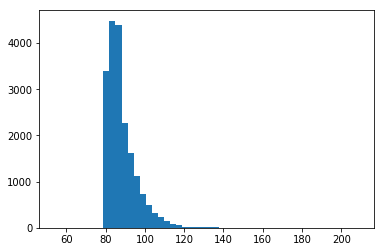

In [11]:
group_df.seq_length.hist(bins=50, c='tab:blue')

In [41]:
a = group_df[group_df.text.str.contains("Stannis glanced into the fire")].text
print(a.values)

['  Is it his fault the old man died? Stannis glanced into the fire.  I never wanted Cressen at that feast. He’d angered me, yes, he’d given me bad counsel, but I did not want him dead.  I’d hoped he might be granted a few years of ease and comfort. He had earned that much, at least, but—he ground his teeth together—but he died. And Pylos serves me ably.  Pylos is the least of it. The letter . . . What did your lords make of it, I wonder?']


In [46]:
group_df.seq_length

0         92
1         85
2         94
3         88
4         86
5         86
6         85
7         84
8         88
9         90
10        82
11        86
12        86
13        90
14        81
15        85
16        90
17        80
18        89
19        81
20        99
21        84
22        83
23        80
24        93
25        83
26        88
27        91
28        88
29        80
        ... 
19408     89
19409     84
19410     85
19411     81
19412     86
19413     83
19414     88
19415     83
19416     85
19417     82
19418    107
19419     82
19420     93
19421     84
19422     97
19423     87
19424     90
19425     83
19426     86
19427     82
19428     90
19429     90
19430     84
19431     92
19432     80
19433     97
19434     86
19435     82
19436     93
19437     89
Name: seq_length, Length: 19438, dtype: int64

In [44]:
group_df.seq_length.min()

54

In [43]:
group_df.seq_length.max()

209

In [70]:
train_df = group_df.loc[:15000]
dev_df = group_df.loc[15000:17500]
test_df = group_df.loc[17500:]

In [71]:
train_df.to_pickle('./Data/train/train.pkl')
dev_df.to_pickle('./Data/dev/dev.pkl')
test_df.to_pickle('./Data/test/test.pkl')

In [72]:
print(len(train_df), len(dev_df), len(test_df))

15001 2501 1938


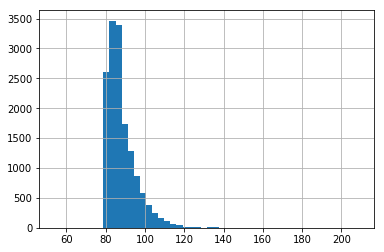

In [79]:
train_df.seq_length.hist(bins=50)
print()

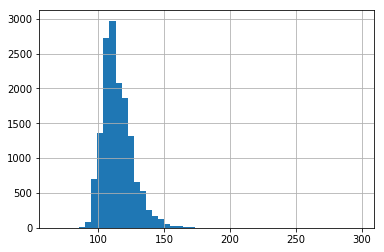

In [80]:
train_df.token_length.hist(bins=50)
print()

In [52]:
dummy = np.array([3,4,5])
dummy_temp = np.array([3,4,5])/0.25
sm_dummy = np.exp(dummy)/np.sum(np.exp(dummy))
sm_dummy_temp = np.exp(dummy_temp)/np.sum(np.exp(dummy_temp))

In [53]:
sm_dummy

array([0.09003057, 0.24472847, 0.66524096])

In [54]:
sm_dummy_temp

array([3.29320439e-04, 1.79802867e-02, 9.81690393e-01])